In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import umap
import warnings

from dirichlet import mle
from scipy.stats import dirichlet
from sklearn.manifold import TSNE
from synthetic_data.wgan.utils import CustomHistory
from synthetic_data.wgan.critics import MLPCritic
from synthetic_data.wgan.generators import MLPGenerator
from synthetic_data.wgan.wgan import WGANGP, critic_loss, generator_loss


warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

tf.__version__

c:\git\nn-flash\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.13.0'

# Dirichlet samples

In [2]:
for filename in glob.glob("data\\experimental\\classification\\001points\\*train*"):
    df = pd.read_csv(filename)
    compositions = df.iloc[:, df.columns.str.contains("z")].drop_duplicates() / 100.0
    alpha = mle(compositions)
    break

# Wasserstein GAN samples

In [3]:
# Training WGAN
latent_dim = 16
lambda_ = 10.0
n_critic = 5
lr = 0.0001
beta_1, beta_2 = 0.5, 0.9
batch_size = 32
epochs = 2000

output_dim = compositions.shape[-1]

print(f"samples, features: {compositions.values.shape}", end="\n\n")
data = compositions.values.astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.batch(batch_size)

critic = MLPCritic(hidden_units=[512, 512, 512])
generator = MLPGenerator(output_dim=output_dim, hidden_units=[512, 512, 512])

critic_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=beta_1,
    beta_2=beta_2,
)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=beta_1,
    beta_2=beta_2,
)

random_latent_vectors = tf.random.normal((440, latent_dim))

# Get the Wasserstein GAN model
wgan = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=latent_dim,
    n_critic=n_critic,
    lambda_=lambda_,
)

# Compile the Wasserstein GAN model
wgan.compile(
    critic_optimizer=critic_optimizer,
    generator_optimizer=generator_optimizer,
    critic_loss_fn=critic_loss,
    generator_loss_fn=generator_loss,
)

callbacks = [CustomHistory()]

wgan.fit(dataset, epochs=epochs, callbacks=callbacks)

neg_critic_loss = -np.array(callbacks[0].history["critic_loss"])
batches = neg_critic_loss.shape[0]


samples, features: (440, 24)

Epoch 1/2000
14/14 [==============================] - 4s 63ms/step - critic_loss: 0.6425 - generator_loss: 0.0215
Epoch 2/2000
14/14 [==============================] - 1s 65ms/step - critic_loss: -0.2220 - generator_loss: -0.0843
Epoch 3/2000
14/14 [==============================] - 1s 65ms/step - critic_loss: -0.1276 - generator_loss: 0.0612
Epoch 4/2000
14/14 [==============================] - 1s 65ms/step - critic_loss: -0.0714 - generator_loss: -0.0196
Epoch 5/2000
14/14 [==============================] - 1s 63ms/step - critic_loss: -0.1099 - generator_loss: 0.1931
Epoch 6/2000
14/14 [==============================] - 1s 64ms/step - critic_loss: -0.0679 - generator_loss: 0.0309
Epoch 7/2000
14/14 [==============================] - 1s 62ms/step - critic_loss: -0.0653 - generator_loss: 0.0213
Epoch 8/2000
14/14 [==============================] - 1s 61ms/step - critic_loss: -0.0420 - generator_loss: 0.0473
Epoch 9/2000
14/14 [=============================

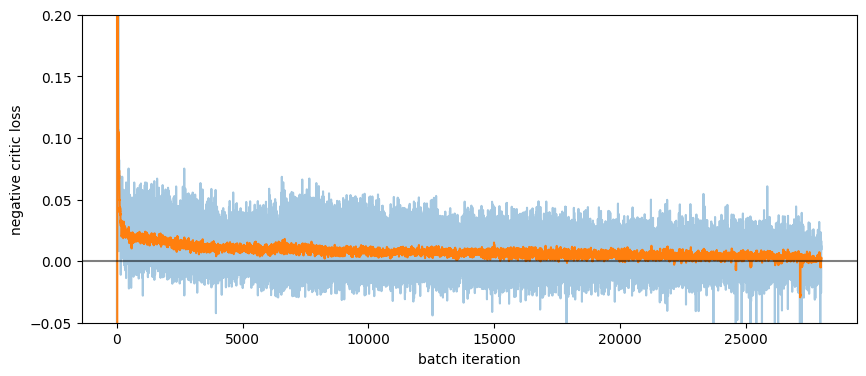

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.arange(batches), neg_critic_loss, alpha=0.4)
ax.plot(np.arange(batches), pd.Series(neg_critic_loss).rolling(20).mean())
ax.set_xlabel("batch iteration")
ax.set_ylabel("negative critic loss")
ax.set_ylim([-0.05, 0.2])
ax.axhline(y=0.0, color=('black', 0.5), linestyle='-')

# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

In [5]:
samples_size = compositions.shape[0]

noise = tf.random.normal([samples_size, 16])


data = np.vstack(
    [
        compositions.values,
        dirichlet.rvs(alpha, size=samples_size),
        generator(noise, training=False),
    ]
)


tsne = TSNE(n_components=2, perplexity=100)
umap_ = umap.UMAP(n_neighbors=50, n_components=2, metric="euclidean", min_dist=0.1)

reduced_tsne = tsne.fit_transform(data)
reduced_umap = umap_.fit_transform(data)

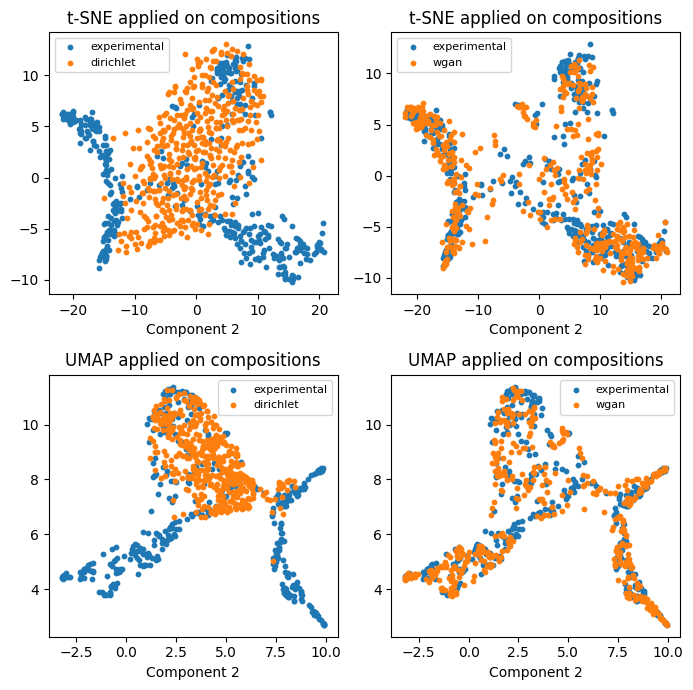

In [6]:
f, ax = plt.subplots(2, 2, figsize=(7, 7))
# t-SNE plots
ax[0, 0].scatter(
    reduced_tsne[:samples_size, 0],
    reduced_tsne[:samples_size, 1],
    s=10,
    label="experimental",
)
ax[0, 0].scatter(
    reduced_tsne[samples_size : 2 * samples_size, 0],
    reduced_tsne[samples_size : 2 * samples_size, 1],
    s=10,
    label="dirichlet",
)
ax[0, 1].scatter(
    reduced_tsne[:samples_size, 0],
    reduced_tsne[:samples_size, 1],
    s=10,
    label="experimental",
)
ax[0, 1].scatter(
    reduced_tsne[2 * samples_size :, 0],
    reduced_tsne[2 * samples_size :, 1],
    s=10,
    label="wgan",
)
ax[0, 0].legend(prop={'size': 8})
ax[0, 1].legend(prop={'size': 8})
# ax[0].grid(True)
ax[0, 0].set_xlabel("Component 1")
ax[0, 1].set_xlabel("Component 1")
ax[0, 0].set_xlabel("Component 2")
ax[0, 1].set_xlabel("Component 2")
ax[0, 0].set_title("t-SNE applied on compositions")
ax[0, 1].set_title("t-SNE applied on compositions")

# UMAP plots
ax[1, 0].scatter(
    reduced_umap[:samples_size, 0],
    reduced_umap[:samples_size, 1],
    s=10,
    label="experimental",
)
ax[1, 0].scatter(
    reduced_umap[samples_size : 2 * samples_size, 0],
    reduced_umap[samples_size : 2 * samples_size, 1],
    s=10,
    label="dirichlet",
)
ax[1, 1].scatter(
    reduced_umap[:samples_size, 0],
    reduced_umap[:samples_size, 1],
    s=10,
    label="experimental",
)
ax[1, 1].scatter(
    reduced_umap[2 * samples_size :, 0],
    reduced_umap[2 * samples_size :, 1],
    s=10,
    label="wgan",
)
ax[1, 0].legend(prop={'size': 8})
ax[1, 1].legend(prop={'size': 8})
# ax[0].grid(True)
ax[1, 0].set_xlabel("Component 1")
ax[1, 1].set_xlabel("Component 1")
ax[1, 0].set_xlabel("Component 2")
ax[1, 1].set_xlabel("Component 2")
ax[1, 0].set_title("UMAP applied on compositions")
ax[1, 1].set_title("UMAP applied on compositions")


f.tight_layout()
plt.show()